<a href="https://colab.research.google.com/github/ciepielajan/Multi-Class-Classification-NLP/blob/main/Detecting_intentions_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Pobranie danych

In [ ]:
# https://drive.google.com/file/d/1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq/view?usp=sharing
!gdown --id "1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq"

Downloading...
From: https://drive.google.com/uc?id=1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq
To: /content/user_intent.zip
100% 271k/271k [00:00<00:00, 37.0MB/s]


In [ ]:
!unzip "user_intent.zip"

Archive:  user_intent.zip
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    
  inflating: validation.csv          


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

data_set_train = pd.read_csv("train.csv")
data_set_valid = pd.read_csv("validation.csv")

print(data_set_train.shape)
print(data_set_valid.shape)

print(data_set_train.columns)
print(data_set_valid.columns)

(13784, 2)
(700, 2)
Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')


#### Podstawowy process text

In [ ]:
import re
def process_text(sentence):
    sentence = re.sub('[A-Za-z0-9]+@[a-zA-z].[a-zA-Z]+', '', sentence)  # maile
    sentence = re.sub('(http[s]*:[/][/])[a-zA-Z0-9]+', '', sentence)  # linki
    sentence = re.sub(r"<[^>]+>", " ", sentence) # remove html tag
    sentence = re.sub(r"[^a-zA-Z\s]", "", sentence)  # remove punctuations and numbers   
    sentence = re.sub(r"\b[A-Za-z]{1}\b", "", sentence)  # remove single characters

    sentence = re.sub("^\s+|\s+$", "", sentence, flags=re.UNICODE) # Remove spaces both in the BEGINNING and in the END of a string:
    sentence = " ".join(re.split("\s+", sentence, flags=re.UNICODE))  # Remove ONLY DUPLICATE spaces:
    sentence = sentence.lower()
    
    return sentence

In [ ]:
data_set_train["clean_text"] = data_set_train["text"].apply(lambda x: process_text(x))

#### `LabelEncoder` oraz `to_categorical`

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical 


labelencoder = LabelEncoder()
data_set_train["labelencoder"] = labelencoder.fit_transform(data_set_train["label"])

dummy_y = to_categorical(data_set_train["labelencoder"], dtype ="float32")

data_set_train[["clean_text","label","labelencoder"]].head(5)

,clean_text,label,labelencoder
0,find cinema nearest for films,SearchScreeningEvent,6
1,give the current series two stars,RateBook,4
2,find the good girl at movie house,SearchScreeningEvent,6
3,please make reservations for three at kosher t...,BookRestaurant,1
4,what is the forecast for here one second from now,GetWeather,2


In [ ]:
dummy_y.shape

(13784, 7)

In [ ]:
id_intention = 6
print("Sprawdzenie poprawności LabelEncoder i to_categorical \n")
print("Label - ", data_set_train["label"].iloc[id_intention])
print("LabelEncoder - ", data_set_train["labelencoder"].iloc[id_intention])
print()
print("to_categorical - ", dummy_y[id_intention])
print()
print("return to LabelEncoder - ",np.argmax(dummy_y[id_intention], axis=-1))
print("return to Label - ",labelencoder.inverse_transform([np.argmax(dummy_y[id_intention], axis=-1)]))

Sprawdzenie poprawności LabelEncoder i to_categorical 

Label -  BookRestaurant
LabelEncoder -  1

to_categorical -  [0. 1. 0. 0. 0. 0. 0.]

return to LabelEncoder -  1
return to Label -  ['BookRestaurant']


#### Zdefiniowanie X i y

In [ ]:
X = data_set_train["clean_text"]
y = dummy_y

In [ ]:
X.shape, y.shape

((13784,), (13784, 7))

#### Podział zbioru 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11027,), (2757,), (11027, 7), (2757, 7))

#### `Tokenizer` i `pad_sequences`

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 7
vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding="post", truncating="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", truncating="post", maxlen=maxlen)

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, SimpleRNN, Dense
from keras.layers.embeddings import Embedding
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=maxlen))  
model.add(Flatten())
model.add(Dense(7, activation="softmax")) # sigmoid / softmax
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7, 100)            976800    
_________________________________________________________________
flatten (Flatten)            (None, 700)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 4907      
Total params: 981,707
Trainable params: 981,707
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

EarlyStop = EarlyStopping(monitor='val_loss', 
                          patience=5,
                          verbose=1)

history = model.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    batch_size=64, 
                    validation_split=0.2, 
                    callbacks = [EarlyStop] )
scores = model.evaluate(X_test, y_test)
print(f"Accuracy {scores[1] * 100}")

Epoch 1/20
138/138 [==============================] - 2s 11ms/step - loss: 1.5810 - accuracy: 0.6923 - val_loss: 0.4084 - val_accuracy: 0.9370
Epoch 2/20
138/138 [==============================] - 1s 8ms/step - loss: 0.2931 - accuracy: 0.9520 - val_loss: 0.1623 - val_accuracy: 0.9619
Epoch 3/20
138/138 [==============================] - 1s 8ms/step - loss: 0.1173 - accuracy: 0.9769 - val_loss: 0.1131 - val_accuracy: 0.9705
Epoch 4/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0655 - accuracy: 0.9884 - val_loss: 0.0932 - val_accuracy: 0.9737
Epoch 5/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0438 - accuracy: 0.9919 - val_loss: 0.0830 - val_accuracy: 0.9760
Epoch 6/20
138/138 [==============================] - 1s 7ms/step - loss: 0.0288 - accuracy: 0.9955 - val_loss: 0.0770 - val_accuracy: 0.9778
Epoch 7/20
138/138 [==============================] - 1s 8ms/step - loss: 0.0223 - accuracy: 0.9964 - val_loss: 0.0738 - val_accuracy: 0.9773
Epoch

#### Predykcja na zbiorze validacyjnym

In [ ]:
# oczysczenie danych
data_set_valid["clean_text"] = data_set_valid["text"].apply(lambda x: process_text(x))

# labelencoder 
data_set_valid["labelencoder"] = labelencoder.fit_transform(data_set_valid["label"])

# tokenizacja weg przetrenowanego już tokenizera
X_validate = tokenizer.texts_to_sequences(data_set_valid["clean_text"])

# pad sequel
X_validate = pad_sequences(X_validate, padding="post", truncating="post", maxlen=maxlen)
X_validate

array([[  15,   42,   50, ...,   44,    6,    1],
       [ 241,  177,   21, ..., 1593,    3,  738],
       [  15,    8,    1, ...,   36,    4,   48],
       ...,
       [  28,    1,   84, ...,   38,    0,    0],
       [  15,    8,    1, ...,   36,    4, 2688],
       [  45,   40,    4, ...,  152,  129,  404]], dtype=int32)

In [ ]:
dummy_y_valid = data_set_valid["labelencoder"].values
dummy_y_valid[:5]

array([6, 3, 2, 0, 6])

In [ ]:
# Sprawdzenie rozmiaru zbiorów validacyjnego
X_validate.shape, dummy_y_valid.shape

((700, 7), (700,))

In [ ]:
predicted_lstm_val = np.argmax(model.predict(X_validate), axis=-1)
predicted_lstm_val[:5]

array([6, 3, 2, 0, 6])

#### Rozkodowanie przewidzianych i prawidłowych etykiet

In [ ]:
y_pred = labelencoder.inverse_transform(predicted_lstm_val)
y_pred = pd.Series(y_pred)
y_pred.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

In [ ]:
y_val = labelencoder.inverse_transform(dummy_y_valid)
y_val = pd.Series(y_val)
y_val.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

#### `Confusion matrix`

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

Accuracy: 0.97
F1_score: 0.97
                      precision    recall  f1-score   support

       AddToPlaylist       0.98      0.99      0.99       100
      BookRestaurant       0.99      0.98      0.98       100
          GetWeather       0.96      0.97      0.97       100
           PlayMusic       1.00      0.97      0.98       100
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       0.91      1.00      0.95       100
SearchScreeningEvent       0.99      0.91      0.95       100

            accuracy                           0.97       700
           macro avg       0.98      0.97      0.97       700
        weighted avg       0.98      0.97      0.97       700



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

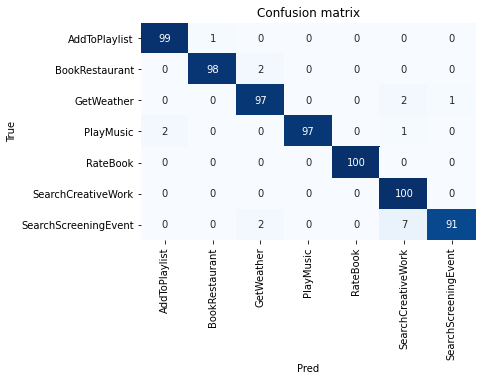

In [ ]:
classes = np.unique(y_val)

print('Accuracy:', round(accuracy_score(y_val, y_pred),2))
print('F1_score:', round(f1_score(y_val, y_pred, average='weighted'),2))

print(classification_report(y_val, y_pred))
# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Pred', ylabel='True', xticklabels=classes, yticklabels=classes, title='Confusion matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=90)

#### Zapoznanie się z błędnymi predykcjami 

In [ ]:
indexes = []
for i, phrase in enumerate(y_pred):
  if phrase == 'SearchCreativeWork':
    if y_val[i] == 'SearchScreeningEvent':
      indexes.append(i)
print(indexes)

[6, 346, 519, 557, 615, 648, 689]


In [ ]:
for i in indexes:
  print(f"----------------------------\nTekst komendy:\n{data_set_valid['text'][i]}")
  print(f"Oczyszczona komenda:\n{data_set_valid['clean_text'][i]}")
  print(f'True category: {y_val[i]}')
  print(f'Predicted category: {y_pred[i]}')
  print("\n")

----------------------------
Tekst komendy:
I want to see While the Sun Shines at the closest movie house.
Oczyszczona komenda:
want to see while the sun shines at the closest movie house
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
I want to see Those Kids from Town, when will it be showing?
Oczyszczona komenda:
want to see those kids from town when will it be showing
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
i want to see JLA Adventures: Trapped In Time
Oczyszczona komenda:
want to see jla adventures trapped in time
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
I want to see Shattered Image.
Oczyszczona komenda:
want to see shattered image
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:

Wnioski:
> Model ma tendencję do faryzowania etykiety SearchCreativeWork kosztem SearchScreeningEvent. Świadczy o tym `100% skutczeność predykcji SearchCreativeWork` przy `91% skuteczności predykcji SearchScreeningEvent`. Sprawdzmy najcześciej pojawiające się słowa w obu etykietach. 

Chciałbym znaleść charakterystyczną `słowo, ngram lub znak specjalny `, który móglby zwiększyć skuteczność wykrycia etykiety `SearchScreeningEvent`. W tym celu sprawdzam ich występowanie w obu mylonych etykietach.

In [78]:
from collections import Counter

def ngrams(text, n):
    return [" ".join(x) for x in zip(*[text[i:] for i in range(n)])]

sprawdzam na danych surowych z których nie zostało nic usunięte

In [80]:
tokens = data_set_train['text'].map(lambda x: ngrams(x.strip().lower().split(), 1)).sum()
print(Counter(tokens).most_common(15))

[('the', 7415), ('a', 4385), ('in', 3437), ('to', 3398), ('for', 3045), ('of', 2563), ('at', 2104), ('play', 1912), ('i', 1843), ('is', 1630), ('book', 1602), ('add', 1578), ('find', 1403), ('my', 1400), ('what', 1208)]
